## Calculating Carbon Stock (updated)

In [1]:
##load data from database

# === 1. Imports ===
import pandas as pd
from sqlalchemy import create_engine

# === 2. Connect to PostgreSQL ===
# Replace with your actual credentials
USER = "inesschwartz"
PASSWORD = "aa4862aa"
HOST = "localhost"
PORT = "5432"
DB = "soils_angola"

engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}")

# === 3. Load data from each table ===
# You can filter early to avoid huge pulls
analyses = pd.read_sql("SELECT * FROM analyses", engine)
morpho = pd.read_sql("SELECT * FROM morpho", engine)
site_info = pd.read_sql("SELECT * FROM site_info", engine)
soil_type = pd.read_sql("SELECT * FROM soil_type", engine)
samples = pd.read_sql("SELECT * FROM samples", engine)
usable_sites = pd.read_sql("SELECT * FROM usable_site_info", engine)
climate_feat = pd.read_sql("SELECT * FROM climate_feat", engine)

In [2]:
# === 4. CREATE MERGED DATASET ===

# Columns to select from analyses
analyses_cols = [
    'analysis_id', 'morpho_id', 'sample_id', 'profile', 'upper_depth', 'lower_depth',
    'thick_sand', 'fine_sand', 'silt', 'clay', 'atm_15', 'free_iron', 
    'organic_carbon', 'p205', 'organic_material', 'ph_h2o', 'ph_kcl', 
    'exchangable_bases_sum', 'cec', 'sample_depth', 'bulk_density', 'porosity'
]

# Subset analyses to relevant columns, ignoring missing cols gracefully
analyses_subset = analyses[[col for col in analyses_cols if col in analyses.columns]].copy()

# Filter analyses and morpho to only profiles present in site_info
valid_profiles = site_info['profile'].dropna().unique()

analyses_filtered = analyses_subset[analyses_subset['profile'].isin(valid_profiles)]
morpho_filtered = morpho[morpho['profile'].isin(valid_profiles)]

# Ensure matching dtypes for merge keys
analyses_filtered['sample_id'] = analyses_filtered['sample_id'].astype(str)
morpho_filtered['sample_id'] = morpho_filtered['sample_id'].astype(str)  # optional, since already object

# Now merge
combined_data = pd.merge(
    analyses_filtered,
    morpho_filtered,
    on=['profile', 'sample_id'],
    how='outer',
    suffixes=('', '_morpho')
)


# Inner join with site_info to keep only profiles with site info
merged_final = pd.merge(
    combined_data,
    site_info,
    on='profile',
    how='inner'
)

# Now merge with samples to add 'year' by sample_id
# Assuming 'samples' DataFrame is loaded and has 'sample_id' and 'year' columns
merged_final = pd.merge(
    merged_final,
    samples[['sample_id', 'year']],
    on='sample_id',
    how='inner'
)


In [3]:
import pandas as pd

## add directly into merged_final
# # Make a proper copy of your dataframe
# df = merged_final.copy()

# ----------------------------
# Step 1 — Before counts
# ----------------------------
initial_nan_oc = merged_final['organic_carbon'].isna().sum()
available_om = merged_final['organic_material'].notna().sum()
both_missing = merged_final[merged_final['organic_carbon'].isna() & merged_final['organic_material'].isna()].shape[0]

print(f"Initial missing organic_carbon: {initial_nan_oc}")
print(f"Rows with organic_material available: {available_om}")
print(f"Rows missing both OC and OM: {both_missing}")

# ----------------------------
# Step 2 — Compute OC from OM (OM = OC × 1.72 → OC = OM ÷ 1.72)
# Only where OC is missing but OM exists
# ----------------------------
merged_final['1organic_carbon'] = merged_final.apply(
    lambda row: row['organic_material'] / 1.72
    if pd.isna(row['organic_carbon']) and pd.notna(row['organic_material'])
    else None,
    axis=1
)

# Count how many new OC values were computed
new_oc_filled = merged_final['1organic_carbon'].notna().sum()
print(f"New organic_carbon values computed from organic_material: {new_oc_filled}")

# ----------------------------
# Step 3 — Fill organic_carbon with computed values
# ----------------------------
merged_final['organic_carbon'] = merged_final['organic_carbon'].fillna(merged_final['1organic_carbon'])

# ----------------------------
# Step 4 — After counts
# ----------------------------
remaining_nan_oc = merged_final['organic_carbon'].isna().sum()
print(f"Remaining missing organic_carbon after filling: {remaining_nan_oc}")

# Optionally drop helper column
merged_final.drop(columns=['1organic_carbon'], inplace=True)

# ----------------------------
# Step 5 — Select relevant columns for analyses
# ----------------------------
analyses_cols = [
    'analysis_id', 'morpho_id', 'sample_id', 'profile', 'upper_depth', 'lower_depth',
    'thick_sand', 'fine_sand', 'silt', 'clay', 'atm_15', 'free_iron', 
    'organic_carbon', 'p205', 'organic_material', 'ph_h2o', 'ph_kcl', 
    'exchangable_bases_sum', 'cec', 'sample_depth', 'bulk_density', 'porosity'
]

df_analyses = merged_final[analyses_cols].copy()

# Optional short summary
print("\n✅ Summary:")
print(f"  → Initially missing OC: {initial_nan_oc}")
print(f"  → New OC computed: {new_oc_filled}")
print(f"  → Remaining missing OC: {remaining_nan_oc}")
print(f"  → Total rows in dataset: {len(merged_final)}")


Initial missing organic_carbon: 2210
Rows with organic_material available: 4497
Rows missing both OC and OM: 2190
New organic_carbon values computed from organic_material: 20
Remaining missing organic_carbon after filling: 2190

✅ Summary:
  → Initially missing OC: 2210
  → New OC computed: 20
  → Remaining missing OC: 2190
  → Total rows in dataset: 6720


In [4]:
## same merged but with usable sites:

# ===  CREATE MERGED DATASET ===

# Columns to select from analyses
analyses_cols = [
    'analysis_id', 'morpho_id', 'sample_id', 'profile', 'upper_depth', 'lower_depth',
    'thick_sand', 'fine_sand', 'silt', 'clay', 'atm_15', 'free_iron', 
    'organic_carbon', 'p205', 'organic_material', 'ph_h2o', 'ph_kcl', 
    'exchangable_bases_sum', 'cec', 'sample_depth', 'bulk_density', 'porosity'
]

# Subset analyses to relevant columns, ignoring missing cols gracefully
analyses_subset = analyses[[col for col in analyses_cols if col in analyses.columns]].copy()

# Filter analyses and morpho to only profiles present in site_info
valid_profiles = usable_sites['profile'].dropna().unique()

analyses_filtered = analyses_subset[analyses_subset['profile'].isin(valid_profiles)]
morpho_filtered = morpho[morpho['profile'].isin(valid_profiles)]

# Ensure matching dtypes for merge keys
analyses_filtered['sample_id'] = analyses_filtered['sample_id'].astype(str)
morpho_filtered['sample_id'] = morpho_filtered['sample_id'].astype(str)  # optional, since already object

# Now merge
combined_data = pd.merge(
    analyses_filtered,
    morpho_filtered,
    on=['profile', 'sample_id'],
    how='outer',
    suffixes=('', '_morpho')
)


# Inner join with site_info to keep only profiles with site info
merged_final1 = pd.merge(
    combined_data,
    usable_sites,
    on='profile',
    how='inner'
)

# Now merge with samples to add 'year' by sample_id
# Assuming 'samples' DataFrame is loaded and has 'sample_id' and 'year' columns
merged_final1 = pd.merge(
    merged_final1,
    samples[['sample_id', 'year']],
    on='sample_id',
    how='inner'
)


/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_9045/477596308.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analyses_filtered['sample_id'] = analyses_filtered['sample_id'].astype(str)
/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_9045/477596308.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_filtered['sample_id'] = morpho_filtered['sample_id'].astype(str)  # optional, since already object


In [5]:
merged_final1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6483 entries, 0 to 6482
Data columns (total 57 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   analysis_id            6446 non-null   object 
 1   morpho_id              6446 non-null   object 
 2   sample_id              6483 non-null   object 
 3   profile                6483 non-null   object 
 4   thick_sand             6091 non-null   float64
 5   fine_sand              6119 non-null   float64
 6   silt                   6096 non-null   float64
 7   clay                   6112 non-null   float64
 8   atm_15                 1802 non-null   float64
 9   free_iron              4545 non-null   float64
 10  organic_carbon         4351 non-null   float64
 11  p205                   1927 non-null   float64
 12  organic_material       4338 non-null   float64
 13  ph_h2o                 5815 non-null   float64
 14  ph_kcl                 5306 non-null   float64
 15  exch

In [6]:
merged_final1.columns

Index(['analysis_id', 'morpho_id', 'sample_id', 'profile', 'thick_sand',
       'fine_sand', 'silt', 'clay', 'atm_15', 'free_iron', 'organic_carbon',
       'p205', 'organic_material', 'ph_h2o', 'ph_kcl', 'exchangable_bases_sum',
       'cec', 'sample_depth', 'bulk_density', 'porosity', 'morpho_id_morpho',
       'horizon_layer', 'upper_depth', 'lower_depth', 'moisture_degree',
       'root_quantity', 'root_diameter', 'texture', 'structure_type',
       'structure_class', 'structure_degree', 'pore_diameter', 'pore_quantity',
       'pore_shape', 'dry_color_name', 'dry_hue', 'dry_value', 'dry_chroma',
       'moist_color_name', 'moist_hue', 'moist_value', 'moist_chroma',
       'compaction', 'durability', 'friability', 'thick_contents_count',
       'thick_contents_nature', 'site_info_id', 'X_coord', 'Y_coord',
       'district', 'geo_features_id', 'climate_id', 'topo_id', 'soil_type_id',
       'geom', 'year'],
      dtype='object')

In [7]:
merged_final1.describe()

,thick_sand,fine_sand,silt,clay,atm_15,free_iron,organic_carbon,p205,organic_material,ph_h2o,...,porosity,horizon_layer,upper_depth,lower_depth,X_coord,Y_coord,geo_features_id,climate_id,topo_id,year
count,6091.000000,6119.000000,6096.000000,6112.000000,1802.000000,4545.000000,4351.000000,1927.000000,4338.000000,5815.000000,...,6446.000000,4993.000000,4993.000000,4992.000000,6483.000000,6483.000000,6483.000000,6483.000000,6483.000000,6483.000000
mean,31.707569,38.730332,6.398146,22.903599,9.182020,1.379771,0.686562,0.109271,1.180850,5.799329,...,0.414959,3.160024,41.660224,72.165264,15.675763,-10.488575,2129.356008,2129.356008,2129.356008,1960.522135
std,20.258469,17.300497,6.768293,16.547386,6.435875,1.502800,0.778963,0.357452,1.337316,0.933806,...,0.153705,1.637473,40.535881,55.332116,2.832795,3.239574,1206.124581,1206.124581,1206.124581,3.229415
min,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.008000,3.800000,...,0.000000,1.000000,0.000000,2.000000,0.000000,-17.998255,1.000000,1.000000,1.000000,1946.000000
25%,14.800000,25.500000,1.900000,9.000000,3.000000,0.390000,0.230000,0.040000,0.400000,5.200000,...,0.380794,2.000000,8.000000,24.000000,14.094121,-12.734926,1092.000000,1092.000000,1092.000000,1958.000000
50%,31.100000,36.800000,4.400000,19.500000,8.000000,0.890000,0.440000,0.060000,0.800000,5.600000,...,0.437945,3.000000,30.000000,60.000000,15.690495,-10.767079,2105.000000,2105.000000,2105.000000,1961.000000
75%,46.100000,50.100000,8.100000,34.000000,13.000000,1.820000,0.860000,0.080000,1.500000,6.200000,...,0.483931,4.000000,67.000000,110.000000,17.081955,-8.315643,3101.000000,3101.000000,3101.000000,1963.000000
max,93.800000,94.200000,64.500000,85.800000,31.000000,21.100000,9.180000,6.000000,19.400000,9.600000,...,2.650000,9.000000,230.000000,266.000000,23.962458,0.000000,4320.000000,4320.000000,4320.000000,1967.000000


Preparing harmonized SOC stock (0–30 cm) according to FAO guidelines, including coarse fragment corrections, spline harmonization, uncertainty propagation, and visualization.

**A Note on Course fragments**

Coarse fragment contents were harmonized from qualitative field descriptions into quantitative percentage ranges using established abundance classes from international soil classification systems (FAO, 2006; IUSS Working Group WRB, 2022; USDA Soil Survey Manual, 2017). Terms such as raro, algum, bastante, muito, abundante, predomínio, and abundantíssimo were aligned with standard volumetric classes of rock fragments: e.g., algum/pouco (<10%), bastante (10–25%), muito (25–45%), abundante (45–55%), predomínio (55–80%), abundantíssimo (>80%), with rare or accidental occurrences assigned 0–2%. When descriptors included ranges (e.g., algum a bastante), the span of the two classes was used, while combinations with e (e.g., muito e algum) were treated as mixtures, with the overall minimum and maximum retained. For each description, a low, high, and midpoint (%) estimate was derived, ensuring both reproducibility and uncertainty tracking in soil organic carbon stock calculations.

References

FAO (2006). Guidelines for Soil Description (4th ed.). FAO, Rome.

IUSS Working Group WRB (2022). World Reference Base for Soil Resources, International soil classification system for naming soils and creating legends for soil maps. 4th edition. IUSS, Vienna.

Soil Survey Staff (2017). Soil Survey Manual. USDA Handbook 18, Washington, D.C.

In [8]:
# dealing with mapping thick_contents_count to a course fragment percentage

import pandas as pd
import numpy as np
import re

# Base mapping: Portuguese terms → (low, high, midpoint)
base_classes = {
    "rarissimo": (0, 2, 1),
    "acidental": (0, 2, 1),
    "raro": (0, 5, 2.5),
    "pouco": (0, 10, 5),
    "algum": (0, 10, 5),
    "bastante": (10, 25, 17.5),
    "muito": (25, 45, 35),
    "abundante": (45, 55, 50),
    "abundantes": (45, 55, 50),
    "abundantissimo": (80, 90, 85),
    "predominio": (55, 80, 67.5),
    "ligeiro predominio": (45, 55, 50),
    "partes sensivelmente iguais": (45, 55, 50),
}

def parse_frag_label(label):
    if pd.isna(label) or str(label).strip() == "" or label.strip() == "0":
        return (0, 0, 0)

    s = str(label).lower()
    # collect all known terms in string
    matches = [v for k, v in base_classes.items() if k in s]

    if not matches:
        return (np.nan, np.nan, np.nan)

    lows = [m[0] for m in matches]
    highs = [m[1] for m in matches]

    low, high = min(lows), max(highs)
    mid = (low + high) / 2
    return (low, high, mid)

# apply to dataframe
merged_final1[["frag_low", "frag_high", "frag_mid"]] = (
    merged_final1["thick_contents_count"]
    .apply(parse_frag_label)
    .apply(pd.Series)
)


## Calculate SOC Stock according to FAO procedures 


Script takes raw soil profile data, harmonizes SOC values to a standard depth interval (0–30 cm) using a mass-preserving spline, corrects for coarse fragments, calculates per-profile SOC stocks, and outputs a clean harmonized dataset.


FAO uses R not python, so functions changed accordingly

In [9]:
# 0) Imports
# ----------------------------------------
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ------------------------------
# Suppress minor spline warnings
# ------------------------------
warnings.filterwarnings("ignore", category=UserWarning)

# ------------------------------
# 1) Specify dataset
# ------------------------------
SOC_dataset = merged_final1[['site_info_id', 'analysis_id', 'profile',
                            'upper_depth', 'lower_depth', 'organic_carbon',
                            'X_coord', 'Y_coord', 'bulk_density',
                            'frag_mid', 'district']].copy()  # only use mid CF for horizon correction

# Harmonize organic carbon units (percent) (is this turning organic_carbon into a percent and then calling it SOC?)
SOC_dataset["soc_percent"] = SOC_dataset["organic_carbon"].apply(
    lambda x: x/10 if x > 50 else x
)

# ------------------------------
# 2) Mass-preserving spline for SOC only (FAO recommendation)
# ------------------------------
def fit_mpspline(depth_top, depth_bottom, values, lam=1.0, target_depths=[0,30]):
    depth_top = np.array(depth_top)
    depth_bottom = np.array(depth_bottom)
    values = np.array(values)
    
    # Remove NaNs
    mask = ~np.isnan(depth_top) & ~np.isnan(depth_bottom) & ~np.isnan(values)
    depth_top = depth_top[mask]
    depth_bottom = depth_bottom[mask]
    values = values[mask]
    
    n = len(values)
    if n == 0:
        return np.nan
    elif n == 1:
        return values[0]
    elif n == 2:
        thickness = depth_bottom - depth_top
        return np.average(values, weights=thickness)
    
    # Compute midpoints and sort
    midpoints = (depth_top + depth_bottom) / 2
    sort_idx = np.argsort(midpoints)
    midpoints = midpoints[sort_idx]
    values = values[sort_idx]
    
    # Remove duplicate midpoints
    unique_midpoints, unique_indices = np.unique(midpoints, return_index=True)
    values = values[unique_indices]
    
    k = min(3, len(values)-1)
    spline = UnivariateSpline(unique_midpoints, values, s=lam, k=k)
    
    top, bottom = target_depths
    integral = spline.integral(top, bottom)
    return integral / (bottom - top)

# ------------------------------
# ------------------------------
# 3) Harmonize profiles and calculate SOC stock
# ------------------------------
profiles = SOC_dataset['profile'].unique()
harmonized_list = []

for pid in profiles:
    # Make an explicit copy of each profile slice (avoids SettingWithCopyWarning)
    profile = SOC_dataset[SOC_dataset['profile'] == pid].copy()
    
    # Skip profiles with no SOC data
    if profile['soc_percent'].isna().all():
        continue
    
    # Harmonize SOC only (0–30 cm) using spline
    soc_h = fit_mpspline(
        depth_top=profile['upper_depth'],
        depth_bottom=profile['lower_depth'],
        values=profile['soc_percent'],
        lam=1.0,
        target_depths=[0, 30]
    )
    
    # Horizon-level BD correction for coarse fragments
    profile['bd_corrected'] = profile['bulk_density'] * (1 - profile['frag_mid'] / 100)
    
    # Adjust horizons to the 0–30 cm interval
    profile['upper_adj'] = profile['upper_depth'].clip(0, 30)
    profile['lower_adj'] = profile['lower_depth'].clip(0, 30)
    profile['thickness_m'] = (profile['lower_adj'] - profile['upper_adj']) / 100  # m

    # Remove horizons that now have zero or negative thickness
    profile = profile[profile['thickness_m'] > 0]

    # Horizon SOC stock (Mg C ha-1)
    profile['soc_stock_horizon'] = (
        profile['bd_corrected'] * profile['thickness_m'] * profile['soc_percent'] * 10
    )

    # Total SOC stock to 30 cm
    soc_stock_0_30 = profile['soc_stock_horizon'].sum()
    
    # Clip negatives to zero, flag if original sum was negative
    soc_stock_0_30_clipped = max(soc_stock_0_30, 0)
    flag_negative = soc_stock_0_30 < 0
    
        # Skip if profile became empty after filtering
    if profile.empty:
        continue

    # Coordinates (all horizons in a profile share same coords → take first row safely)
    x_coord = profile["X_coord"].iloc[0]
    y_coord = profile["Y_coord"].iloc[0]

    ## apend district
    district = profile["district"].iloc[0]

    ## apend site_info_id
    site_info_id = profile["site_info_id"].iloc[0]

    
    # Append to results
    harmonized_list.append({
        'profile': pid,
        'soc_harmonized_percent': soc_h,
        'soc_stock_0_30cm': soc_stock_0_30_clipped,
        'X_coord': x_coord,
        'Y_coord': y_coord,
        'district': district,
        'site_info_id': site_info_id
    })

    
# ------------------------------
# 4) Create final dataframe
# ------------------------------
harmonized_df = pd.DataFrame(harmonized_list)
harmonized_df.dropna(subset=['soc_harmonized_percent'], inplace=True)

# Preview
print(harmonized_df.head())
print(harmonized_df['soc_stock_0_30cm'].describe())

# ----------------------------------------
# 5) Optional: save harmonized dataset
# ----------------------------------------
harmonized_df.to_csv("/Users/inesschwartz/Desktop/cleandata/harmonized_soc_0_30cm.csv", index=False)

   profile  soc_harmonized_percent  soc_stock_0_30cm    X_coord    Y_coord  \
0   100_56                0.723829          3.124415  16.269295 -12.580465   
1   100_58                1.229639          4.829379  13.950172 -12.035300   
2   100_59                0.755000          1.305039  12.733427  -4.627420   
3   100_63                0.353306          2.223432  18.115896 -11.460891   
4  101A_58                0.767291          3.384241  13.935472 -12.058784   

   district site_info_id  
0    Huambo         2139  
1  Benguela         1927  
2   Cabinda           17  
3   Malanje         1701  
4  Benguela         1934  
count    924.000000
mean       3.599636
std        3.047393
min        0.000000
25%        1.851715
50%        2.994280
75%        4.387727
max       40.471545
Name: soc_stock_0_30cm, dtype: float64


In [10]:
# Estimate organic carbon stock (OCS) # SOC must be in g/kg # BLD in kg/m3 # CRF in percentage %  OCSKGM <- OCSKGM(ORCDRC = dat$SOC, BLD = dat$BLD*1000, CRFVOL = dat$CRFVOL, HSIZE = 30)  dat$OCSKGM <- OCSKGM dat$meaERROR <- attr(OCSKGM,"measurementError") dat <- dat[dat$OCSKGM>0,]  summary(dat)  ## id Y

In [11]:
harmonized_df.head()

,profile,soc_harmonized_percent,soc_stock_0_30cm,X_coord,Y_coord,district,site_info_id
0,100_56,0.723829,3.124415,16.269295,-12.580465,Huambo,2139
1,100_58,1.229639,4.829379,13.950172,-12.035300,Benguela,1927
2,100_59,0.755000,1.305039,12.733427,-4.627420,Cabinda,17
3,100_63,0.353306,2.223432,18.115896,-11.460891,Malanje,1701
4,101A_58,0.767291,3.384241,13.935472,-12.058784,Benguela,1934


In [12]:
# 6) Descriptive statistics for SOC percent and SOC stock

summary_stats = harmonized_df[["soc_harmonized_percent", "soc_stock_0_30cm"]].describe()
print(summary_stats)


       soc_harmonized_percent  soc_stock_0_30cm
count              924.000000        924.000000
mean                 0.690288          3.599636
std                  0.666724          3.047393
min                  0.000000          0.000000
25%                  0.325336          1.851715
50%                  0.543945          2.994280
75%                  0.851885          4.387727
max                  9.050000         40.471545


In [13]:
## drop null x and y coords

import pandas as pd

# Identify rows where X_coord or Y_coord is NaN or 0.0
mask_problematic = (
    harmonized_df['X_coord'].isnull() |
    (harmonized_df['X_coord'] == 0.0) |
    harmonized_df['Y_coord'].isnull() |
    (harmonized_df['Y_coord'] == 0.0)
)

# Drop problematic rows
harmonized_df_clean = harmonized_df[~mask_problematic].copy()

# Optional: reset index
harmonized_df_clean.reset_index(drop=True, inplace=True)

# Report
print(f"Dropped {mask_problematic.sum()} problematic rows.")
print(f"Remaining rows: {len(harmonized_df_clean)}")

Dropped 8 problematic rows.
Remaining rows: 916


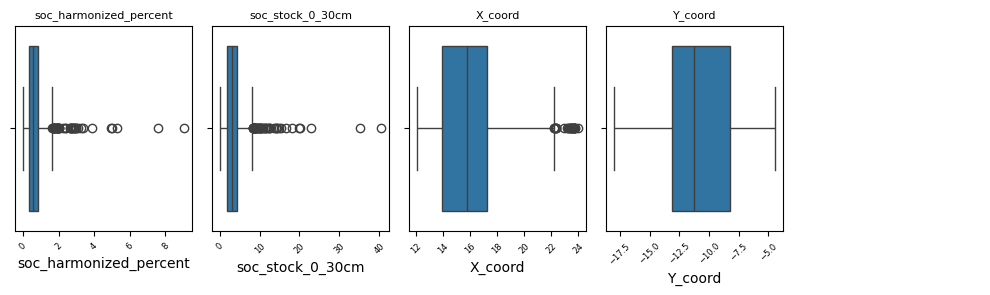

In [14]:
## identify outliers
## check for outliers
numeric_cols = harmonized_df_clean.select_dtypes(include=['float64', 'int64']).columns
harmonized_df_clean[numeric_cols].describe()

#IQR method
Q1 = harmonized_df_clean[numeric_cols].quantile(0.25)
Q3 = harmonized_df_clean[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((harmonized_df_clean[numeric_cols] < (Q1 - 1.5 * IQR)) | 
            (harmonized_df_clean[numeric_cols] > (Q3 + 1.5 * IQR)))

import matplotlib.pyplot as plt
import seaborn as sns
## set up figure w multiple subplots
# Set up the figure with multiple subplots
num_vars = len(numeric_cols)
cols_per_row = 5  # number of boxplots per row
rows = (num_vars + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row*2, rows*3))
axes = axes.flatten()  # flatten in case of multiple rows

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=harmonized_df_clean[col], ax=axes[i])
    axes[i].set_title(col, fontsize=8)
    axes[i].tick_params(axis='x', labelrotation=45, labelsize=6)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


1) If the log-transformation of the response variable (SOC) tends to normality; and 
2) If this transformation increases the simple correlation of SOC and its prediction factors.

In [15]:
# make this python
# Generate a new column with the transformed OCSKGM to its natural 
# # logarithm  dat$OCSKGMlog <- log(dat$OCSKGM)  
# Plot the next two plots as one 
# par(mfrow=c(1,2))  plot(density(dat$OCSKGM),  main='Original values')  
# plot(density(dat$OCSKGMlog), main='Log-transformed values')

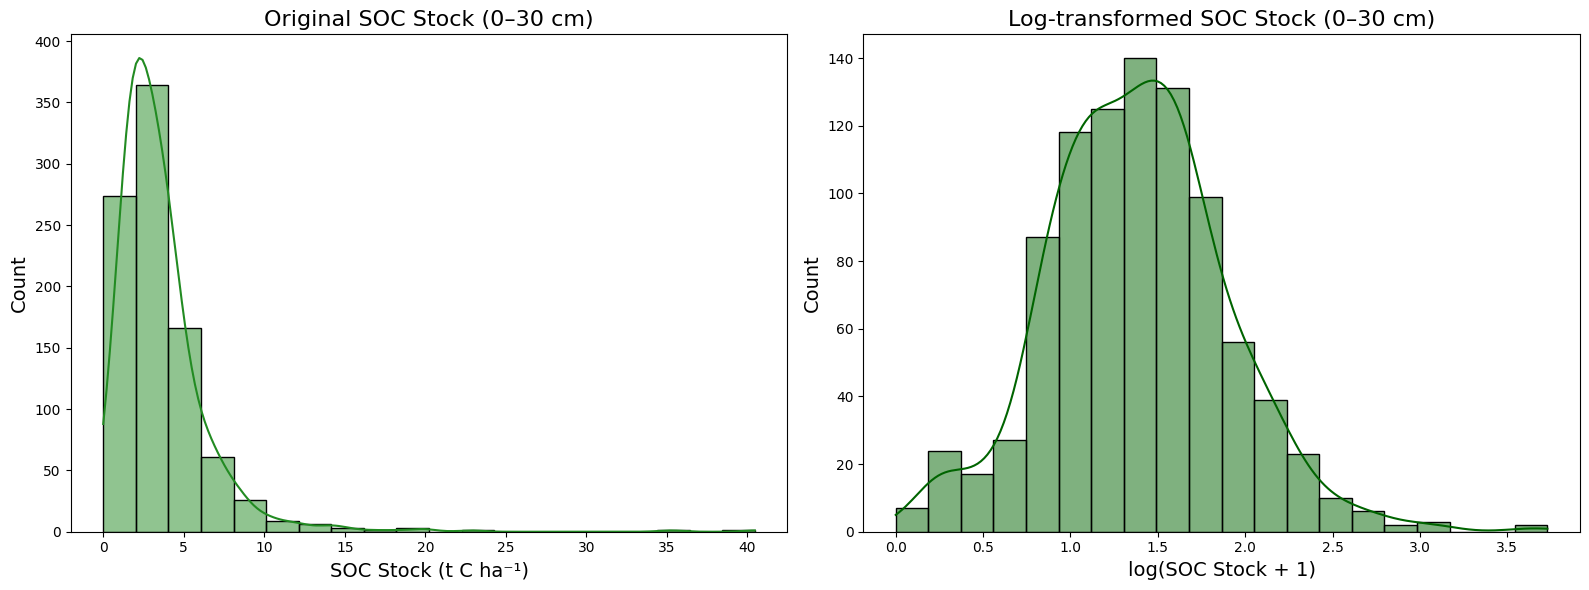

In [16]:
# 7) Histogram of SOC stock (right-skew meaning = fewer higher values) vs log-transformed

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Log-transform SOC stock and round to 2 decimals
harmonized_df_clean['log_soc_stock'] = np.log1p(harmonized_df_clean['soc_stock_0_30cm']).round(2)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Original SOC histogram
sns.histplot(
    harmonized_df_clean['soc_stock_0_30cm'], 
    bins=20, kde=True, color='forestgreen', ax=axes[0]
)
axes[0].set_title('Original SOC Stock (0–30 cm)', fontsize=16)
axes[0].set_xlabel('SOC Stock (t C ha⁻¹)', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)

# Log-transformed SOC histogram
sns.histplot(
    harmonized_df_clean['log_soc_stock'], 
    bins=20, kde=True, color='darkgreen', ax=axes[1]
)
axes[1].set_title('Log-transformed SOC Stock (0–30 cm)', fontsize=16)
axes[1].set_xlabel('log(SOC Stock + 1)', fontsize=14)
axes[1].set_ylabel('Count', fontsize=14)

plt.tight_layout()
plt.show()

# # Save the DataFrame with log-transformed SOC to a CSV
# harmonized_df_clean.to_csv(
#     "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/harmonized_soc_with_log.csv",
#     index=False
# )

harmonized_df_clean.to_csv(
    "/Users/inesschwartz/Desktop//harmonized_soc_with_log.csv",
    index=False
)



In [17]:
from scipy.stats import shapiro

stat, p = shapiro(harmonized_df_clean['log_soc_stock'])
print('Shapiro-Wilk Test: stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print("The log-transformed SOC appears normally distributed.")
else:
    print("The log-transformed SOC may still deviate from normality.")


Shapiro-Wilk Test: stat=0.989, p=0.000
The log-transformed SOC may still deviate from normality.


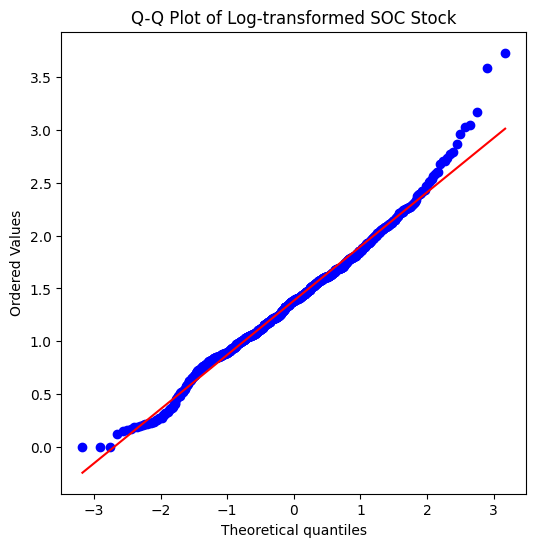

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Q-Q plot
plt.figure(figsize=(6,6))
stats.probplot(harmonized_df_clean['log_soc_stock'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Log-transformed SOC Stock')
plt.show()


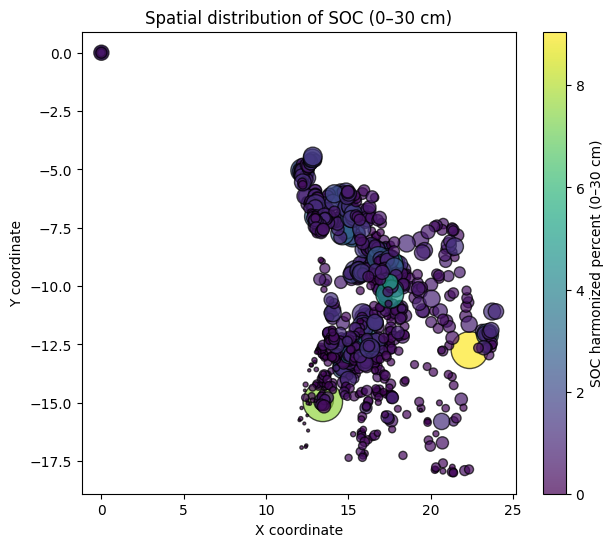

In [19]:
# 8) Scatter plot of profiles

plt.figure(figsize=(7,6))
plt.scatter(
    harmonized_df["X_coord"], harmonized_df["Y_coord"],
    s=harmonized_df["soc_stock_0_30cm"]*20,  # bubble size proportional to SOC stock
    c=harmonized_df["soc_harmonized_percent"], cmap="viridis", alpha=0.7, edgecolor="k"
)
plt.colorbar(label="SOC harmonized percent (0–30 cm)")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Spatial distribution of SOC (0–30 cm)")
plt.show()


SAve log transformed soc stock to csv



In [20]:
harmonized_df.head()

,profile,soc_harmonized_percent,soc_stock_0_30cm,X_coord,Y_coord,district,site_info_id
0,100_56,0.723829,3.124415,16.269295,-12.580465,Huambo,2139
1,100_58,1.229639,4.829379,13.950172,-12.035300,Benguela,1927
2,100_59,0.755000,1.305039,12.733427,-4.627420,Cabinda,17
3,100_63,0.353306,2.223432,18.115896,-11.460891,Malanje,1701
4,101A_58,0.767291,3.384241,13.935472,-12.058784,Benguela,1934
